## Dataset and Problem Introduction

<p>This notebook walks through building a model that can automatically detect honey bees and bumble bees.</p>

Data Source: https://beespotter.org/
<br>Reference: https://www.datacamp.com/

In [1]:
# used to change filepaths
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import display
%matplotlib inline

import pandas as pd
import numpy as np

# import Image from PIL
from PIL import Image

from skimage.feature import hog
from skimage.color import rgb2grey

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# import train_test_split from sklearn's model selection module
from sklearn.model_selection import train_test_split

# import SVC from sklearn's svm module
from sklearn.svm import SVC

# import accuracy_score from sklearn's metrics module
from sklearn.metrics import roc_curve, auc, accuracy_score

## Display image of each bee type
<p>We load our <code>half-labels.csv</code> (only half of the labels are used in this project) file into a dataframe called <code>labels</code>, where the index is the image name (e.g. an index of 1036 refers to an image named 1036.jpg) and the <code>genus</code> column tells us the bee type. <code>genus</code> takes the value of either <code>0.0</code> (Apis or honey bee) or <code>1.0</code> (Bombus or bumble bee).</p>
<p>The function <code>get_image</code> converts an index value from the dataframe into a file path where the image is located, opens the image using the <a href="https://pillow.readthedocs.io/en/5.1.x/reference/Image.html">Image</a> object in Pillow, and then returns the image as a numpy array.</p>

,genus
id,
520,1
3800,1
3289,1
2695,1
4922,1


Honey Bee


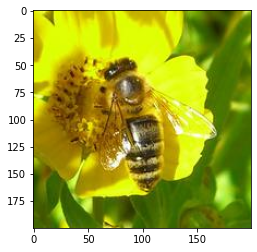

Bumble Bee


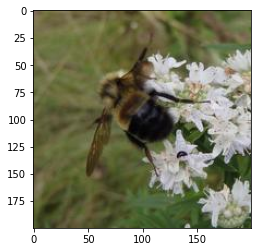

In [2]:
# load the labels using pandas
labels = pd.read_csv("datasets/half-labels.csv", index_col=0)

# show the first five rows of the dataframe using head
display(labels.head())

def get_image(row_id, root="datasets/images/"):
    """
    Converts an image number into the file path where the image is located, 
    opens the image, and returns the image as a numpy array.
    """
    filename = "{}.jpg".format(row_id)
    file_path = os.path.join(root, filename)
    img = Image.open(file_path)
    return np.array(img)

# subset the dataframe to just Apis (genus is 0.0) get the value of the sixth item in the index
apis_row = labels[labels.genus == 0.0].index[0]

# show the corresponding image of an Apis
plt.imshow(get_image(apis_row))
print('Honey Bee')
plt.show()

# subset the dataframe to just Bombus (genus is 1.0) get the value of the sixth item in the index
bombus_row = labels[labels.genus == 1.0].index[0]

# show the corresponding image of a Bombus
plt.imshow(get_image(bombus_row))
print('Bumble Bee')
plt.show()

## Image manipulation with rgb2grey
<p>Scikit-image has a number of image processing functions built into the library, for example, converting an image to greyscale. The <a href="http://scikit-image.org/docs/dev/api/skimage.color.html#skimage.color.rgb2grey"><code>rgb2grey</code></a> function computes the luminance of an RGB image using the following formula <code>Y = 0.2125 R + 0.7154 G + 0.0721 B</code>. </p>
<p>Image data is represented as a matrix, where the depth is the number of channels. An RGB image has three channels (red, green, and blue) whereas the returned greyscale image has only one channel. Accordingly, the original colour image has the dimensions <code>200x200x3</code> but after calling <code>rgb2grey</code>, the resulting greyscale image has only one channel, making the dimensions <code>200x200x1</code>.</p>

Color bombus image has shape:  (200, 200, 3)
Greyscale bombus image has shape:  (200, 200)


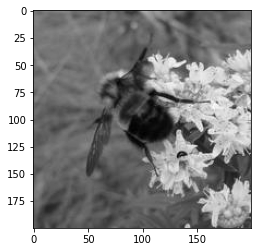

In [3]:
# load a bombus image using our get_image function and bombus_row from the previous cell
bombus = get_image(bombus_row)

# print the shape of the bombus image
print('Color bombus image has shape: ', bombus.shape)

# convert the bombus image to greyscale
grey_bombus = rgb2grey(bombus)

# show the greyscale image
plt.imshow(grey_bombus, cmap=mpl.cm.gray)

# confirm greyscale bombus image only has one channel
print('Greyscale bombus image has shape: ', grey_bombus.shape)

## Histogram of oriented gradients
<p>Now we need to turn these images into something that a machine learning algorithm can understand. Traditional computer vision techniques have relied on mathematical transforms to turn images into useful features. For example, you may want to detect edges of objects in an image, increase the contrast, or filter out particular colours.</p>
<p>We've got a matrix of pixel values, but those don't contain enough interesting information on their own for most algorithms. We need to help the algorithms along by picking out some of the salient features for them using the <a href="http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html">histogram of oriented gradients</a> (HOG) descriptor. The idea behind <a href="https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients">HOG</a> is that an object's shape within an image can be inferred by its edges, and a way to identify edges is by looking at the direction of intensity gradients (i.e. changes in luminescence). </p>
<p>An image is divided in a grid fashion into cells, and for the pixels within each cell, a histogram of gradient directions is compiled. To improve invariance to highlights and shadows in an image, cells are block normalized, meaning an intensity value is calculated for a larger region of an image called a block and used to contrast normalize all cell-level histograms within each block. The HOG feature vector for the image is the concatenation of these cell-level histograms.</p>

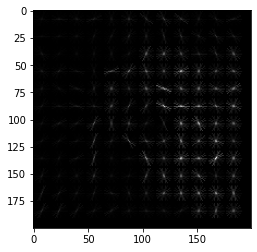

In [4]:
# run HOG using our greyscale bombus image
hog_features, hog_image = hog(grey_bombus,
                              visualize=True,
                              block_norm='L2-Hys',
                              pixels_per_cell=(16, 16))

# show our hog_image with a grey colormap
plt.imshow(hog_image, cmap=mpl.cm.gray)

## Create image features and flatten into a single row
<p>Algorithms require data to be in a format where rows correspond to images and columns correspond to features. This means that all the information for a given image needs to be contained in a single row.</p>
<p>We now provide our model with the raw pixel values from our images as well as the HOG features we just calculated. To do this, we write a function called <code>create_features</code> that combines these two sets of features by flattening the three-dimensional array into a one-dimensional (flat) array.</p>

In [5]:
def create_features(img):
    # flatten three channel color image
    color_features = img.flatten()
    # convert image to greyscale
    grey_image = rgb2grey(img)
    # get HOG features from greyscale image
    hog_features = hog(grey_image, block_norm='L2-Hys', pixels_per_cell=(16, 16))
    # combine color and hog features into a single array
    flat_features = np.hstack([color_features, hog_features])
    return flat_features

bombus_features = create_features(bombus)

# print shape of bombus_features
bombus_features.shape

(128100,)

## Pre-processing images
<p>Now we create features for each image and stack the flattened features arrays into a matrix that we can pass into our model.</p>
<p>In the <code>create_feature_matrix</code> function, we do the following:</p>
<ul>
<li>Load an image</li>
<li>Generate a row of features using the <code>create_features</code> function above</li>
<li>Stack the rows into a features matrix</li>
</ul>
<p>In the resulting features matrix, rows correspond to images and columns to features.</p>

In [6]:
def create_feature_matrix(label_dataframe):
    features_list = []
    
    for img_id in label_dataframe.index:
        # load image
        img = get_image(img_id)
        # get features
        image_features = create_features(img)
        features_list.append(image_features)
        
    # convert list of arrays into a matrix
    feature_matrix = np.array(features_list)
    return feature_matrix

# run create_feature_matrix on our dataframe of images
feature_matrix = create_feature_matrix(labels)

## Scale feature matrix & Principal Component Analysis (PCA)
<p>Many machine learning methods are built to work with data that has a mean of 0 and a unit variance. Scikit-learn <a href="http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html">provides a simple way</a> to rescale data to work using <code>StandardScaler</code>.
<p>We have over 128,000 features for each image and only 500 images total. To use an SVM, we also need to reduce the number of features we have using <a href="http://scikit-learn.org/stable/modules/decomposition.html#pca">principal component analysis</a> (PCA). </p>
<p>PCA is a way of linearly transforming the data such that most of the information in the data is contained within a smaller number of features called components. For our model, we keep 500 components, so our feature matrix will only have 500 columns rather than the original 128,100.</p>

In [7]:
# get shape of feature matrix
print('Feature matrix shape is: ', feature_matrix.shape)

# define standard scaler
ss = StandardScaler()
# run this on our feature matrix
bees_stand = ss.fit_transform(feature_matrix)

pca = PCA(n_components=500)
# use fit_transform to run PCA on our standardized matrix
bees_pca = pca.fit_transform(bees_stand)
# look at new shape
print('PCA matrix shape is: ', bees_pca.shape)

Feature matrix shape is:  (500, 128100)
PCA matrix shape is:  (500, 500)


## Split into train and test sets
<p>Now we convert our data into training and testing sets. We use 70% of images as our training data and test our model on the remaining 30%. Scikit-learn's <a href="http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html"><code>train_test_split</code></a> function makes this easy.</p>

In [8]:
X_train, X_test, y_train, y_test = train_test_split(bees_pca,
                                                    labels.genus.values,
                                                    test_size=.30,
                                                    random_state=8)

# look at the distrubution of labels in the train set
pd.Series(y_train).value_counts()

0    176
1    174
dtype: int64

## Training the model
<p>To build our model we use a <a href="http://scikit-learn.org/stable/modules/svm.html">support vector machine</a> (SVM), a type of supervised machine learning model used for regression, classification, and outlier detection. </p>
<p>Since we have a classification task (honey bee or bumble bee), we use the support vector classifier (SVC) type of SVM.</p>

In [9]:
# define support vector classifier
svm = SVC(kernel='linear', probability=True, random_state=3)

# fit model
svm.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=3,
  shrinking=True, tol=0.001, verbose=False)

## Model score
<p>Now we use our trained model to generate predictions for the test data. To see how well our model did, we calculate the accuracy by comparing our predicted labels for the test set with the true labels in the test set.</p> 
    
<p>Accuracy is the number of correct predictions divided by the total number of predictions, and we calculate this using Scikit-learn's <a href="http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html"><code>accuracy_score</code></a> function. Sometimes accuracy can be misleading, but since we have an equal number of honey and bumble bees, it is a useful metric for this problem.</p>

In [10]:
# generate predictions
y_pred = svm.predict(X_test)

# calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Model accuracy is: ', accuracy)

Model accuracy is:  0.6666666666666666


## ROC curve + AUC
<p>Above we used <code>svm.predict</code> to predict either <code>0.0</code> or <code>1.0</code> for each image in <code>X_test</code>. Now, we use <code>svm.predict_proba</code> to get the probability that <strong>each class</strong> is the true label. For example, if <code>predict_proba</code> returns <code>[0.46195176, 0.53804824]</code> for an image, this means that there is a 46% chance that the bee is an Apis (<code>0.0</code>) and a 53% chance that the bee is a Bombus (<code>1.0</code>). Note that the two probabilities for each image always sum to 1. </p>
<p>Using the default settings, probabilities of 0.5 or above are assigned a class label of <code>1.0</code>, and those below are assigned a <code>0.0</code>. However, this threshold can be adjusted. The <a href="https://en.wikipedia.org/wiki/Receiver_operating_characteristic">receiver operating characteristic curve</a> (ROC curve) plots the false positive rate and true positive rate at different thresholds. ROC curves are judged visually by how close they are to the upper left-hand corner. </p>
<p>The <a href="https://en.wikipedia.org/wiki/Receiver_operating_characteristic#Area_under_the_curve">area under the curve</a> (AUC) is also calculated, where 1 means every predicted label was correct. Generally, the worst score for AUC is 0.5, which is the performance of a model that randomly guesses.</p>

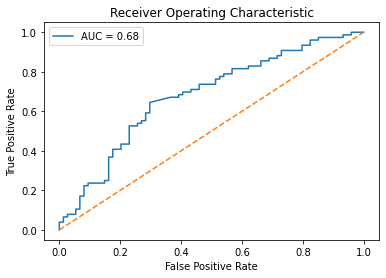

In [11]:
# predict probabilities for X_test using predict_proba
probabilities = svm.predict_proba(X_test)

# select the probabilities for label 1.0
y_proba = probabilities[:, 1]

# calculate false positive rate and true positive rate at different thresholds
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_proba, pos_label=1)

# calculate AUC
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
# plot the false positive rate on the x axis and the true positive rate on the y axis
roc_plot = plt.plot(false_positive_rate,
                    true_positive_rate,
                    label='AUC = {:0.2f}'.format(roc_auc))

plt.legend(loc=0)
plt.plot([0,1], [0,1], ls='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate');